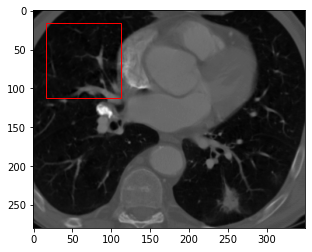

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import fsolve
from scipy.special import digamma
%matplotlib inline
from ct_charachterization.utility.utils import central_gamma_pdf
from glob import glob
import pydicom as dicom
import dicom_numpy
import numpy as np
import SimpleITK as sitk
from matplotlib import pyplot as plt
from scipy.stats import mode



import matplotlib.patches as patches
img = np.load(f'''../resources/luna_cropped.npy''')
fig1, ax1 = plt.subplots(1)
ax1.imshow(img, cmap='gray')
rect = patches.Rectangle((16, 16),96,96,linewidth=1,edgecolor='r',facecolor='none')
ax1.add_patch(rect)
plt.show()
mu = np.array([-987, -810, -540, -370, -160, 0, 100, 240, 340])

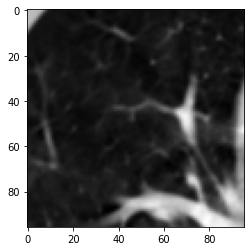

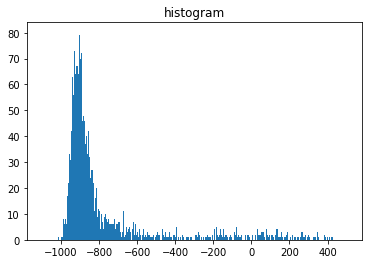

min: -1024, mean: -772.1635199652778, max: 448


In [2]:
to_be_shown = img[16:112,16:112]
plt.imshow(to_be_shown, cmap='gray')
plt.show()

flat = to_be_shown.flatten()
ax = plt.subplot(1, 1, 1)
ax.hist(flat, bins=list(np.arange(-1100, 500, 1)))
plt.title("histogram")
plt.show()
print(f'min: {np.min(flat)}, mean: {np.mean(flat)}, max: {np.max(flat)}')

# Problem Definition

In the algorithm 3 of the paper, there is something weird with the line before return (line 8 of the algorithm).
Except for the radical y, other matrices have two variables, r and j.
I noticed that this was a typo and they do not have in their equations below:

![](../resources/figs/eq40_eq41.png)


They have multiplied the matrices by pi and made a summation on all js.
OK, Let's try it.

# Using Pi As Probability
Let's use pi of theta resulting from the algorithm 2 to reach the resulting image.

In [3]:
import numpy as np
from ct_charachterization.utility.utils import broadcast_tile, block_matrix, sum_over_each_neighborhood_on_blocked_matrix
from ct_charachterization import run_second_algorithm


def run_third_algorithm_with_pi(y: np.array, mu: np.array, neighborhood_size: int, delta=-1030, max_iter=10, tol=0.0000001,
                        constant_c=10, non_central=False):
    big_jay = len(mu)
    if non_central:
        mu = mu - delta
        y = y - delta
    theta, gamma = run_second_algorithm(y, mu=mu, neighborhood_size=neighborhood_size, delta=delta, max_iter=max_iter,
                                        tol=tol)
    pi = theta[0, ...]
    axes = list(range(len(pi.shape)))
    axes.pop(0)
    axes.append(0)
    pi = np.transpose(pi, axes=axes)
    times_pi_to_be_broad_casted = np.array(np.array(y.shape) / np.array(pi.shape[:-1]), dtype=int)
    pi = broadcast_tile(pi, tuple(list(times_pi_to_be_broad_casted) + [1]))
    shape_of_each_neighborhood = tuple([neighborhood_size for _ in y.shape])
    blocked_y = block_matrix(mat=y, neighborhood_shape=shape_of_each_neighborhood)
    blocked_radical_y = block_matrix(mat=np.sqrt(y), neighborhood_shape=shape_of_each_neighborhood)
    moments_size = tuple(list(y.shape) + [big_jay])
    first_local_sample_conditioned_moment = np.empty(moments_size, dtype=float)
    second_local_sample_conditioned_moment = np.empty(moments_size, dtype=float)
    for j in range(big_jay):
        blocked_gamma_j = block_matrix(mat=gamma[..., j], neighborhood_shape=shape_of_each_neighborhood)
        first_numerator_summation = broadcast_tile(
            sum_over_each_neighborhood_on_blocked_matrix(blocked_gamma_j * blocked_radical_y),
            shape_of_each_neighborhood)
        second_numerator_summation = broadcast_tile(
            sum_over_each_neighborhood_on_blocked_matrix(blocked_gamma_j * blocked_y), shape_of_each_neighborhood)
        denominator_summation = broadcast_tile(sum_over_each_neighborhood_on_blocked_matrix(blocked_gamma_j),
                                               shape_of_each_neighborhood)
        first_local_sample_conditioned_moment[..., j] = first_numerator_summation / denominator_summation
        second_local_sample_conditioned_moment[..., j] = second_numerator_summation / denominator_summation
    first_local_sample_conditioned_moment = np.sum(first_local_sample_conditioned_moment * pi, axis=-1)
    second_local_sample_conditioned_moment = np.sum(second_local_sample_conditioned_moment * pi, axis=-1)
    local_sample_variance = second_local_sample_conditioned_moment - np.power(first_local_sample_conditioned_moment, 2)
    y_stab = (constant_c * (np.sqrt(y) - first_local_sample_conditioned_moment) / np.sqrt(
        local_sample_variance)) + second_local_sample_conditioned_moment
    return y_stab


Here, I want to make a neighborhood for every single voxel.
I use the expand function (discussed in the previous notebooks).
The expanded image will be very big and may take a long time for the execution to be finished. (about a minute)

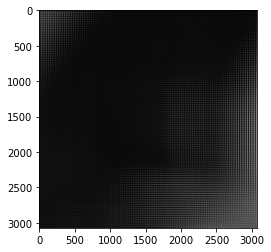

/Users/mostafa/PycharmProjects/ncg/ct_charachterization/_first_algorithm.py:10: RuntimeWarning: invalid value encountered in log
  alpha_optimizer = lambda alpha_var: right_hand_side - (np.log(alpha_var) - digamma(alpha_var))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


iteration: 1, error: 0.1222940508373219
iteration: 2, error: 0.0


/Users/mostafa/PycharmProjects/ncg/ct_charachterization/_first_algorithm.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  theta_before_expansion = np.array([initial_pi, initial_alpha, initial_beta])


iteration: 1, error: 0.26056151999985916
iteration: 2, error: 0.004762949050374908
iteration: 3, error: 0.22150351227457615
iteration: 4, error: 0.004216536692167803
iteration: 5, error: 0.18215492921491022


In [4]:
from ct_charachterization.utility.utils import broadcast_tile, block_matrix, \
    sum_over_each_neighborhood_on_blocked_matrix, expand, contract, central_gamma_pdf


y = img[0:128,0:128]
big_y = expand(small_img=y, neighborhood_size=32)
big_y = big_y[16 * 32:(128-16) * 32, 16 * 32:(128-16) * 32]
plt.imshow(big_y, cmap='gray')
plt.show()
big_y_stab = run_third_algorithm_with_pi(big_y, mu, non_central=True, constant_c=10, neighborhood_size=32, max_iter=5)
y_stab = contract(big_img=big_y_stab, neighborhood_size=32)
sy = y_stab

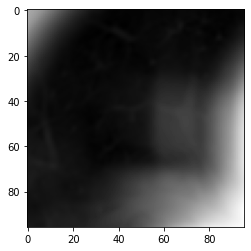

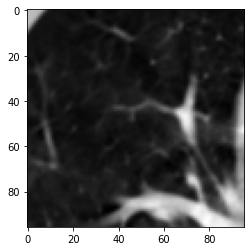

In [5]:
y = img[16:112,16:112]
plt.imshow(sy, cmap='gray')
plt.show()
plt.imshow(y, cmap='gray')
plt.show()

But it doesn't look like the original one! the image is blurred.

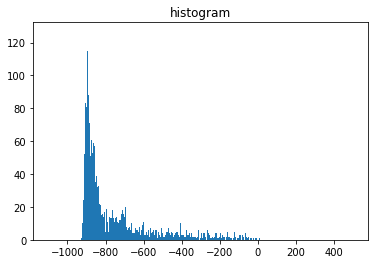

min: -927.4231005973639, mean: -749.2622950321185, max: 12.027654447023224


In [6]:
flat = sy.flatten() - 1030
ax = plt.subplot(1, 1, 1)
ax.hist(flat, bins=list(np.arange(-1100, 500, 1)))
plt.title("histogram")
plt.show()
print(f'min: {np.min(flat)}, mean: {np.mean(flat)}, max: {np.max(flat)}')

# OK let's try just one other possibility
I was thinking that there might be a typo too!
So maybe we should use posterior probability instead of pi!

# Using Gamma As Probability
Gamma variable is the posterior probability, according to the paper:

![gamma](../resources/figs/eq18_eq19.png)

In [7]:
import numpy as np
from ct_charachterization.utility.utils import broadcast_tile, block_matrix, sum_over_each_neighborhood_on_blocked_matrix
from ct_charachterization import run_second_algorithm


def run_third_algorithm_with_gamma(y: np.array, mu: np.array, neighborhood_size: int, delta=-1030, max_iter=10, tol=0.0000001,
                        constant_c=10, non_central=False):
    big_jay = len(mu)
    if non_central:
        mu = mu - delta
        y = y - delta
    theta, gamma = run_second_algorithm(y, mu=mu, neighborhood_size=neighborhood_size, delta=delta, max_iter=max_iter,
                                        tol=tol)
    shape_of_each_neighborhood = tuple([neighborhood_size for _ in y.shape])
    blocked_y = block_matrix(mat=y, neighborhood_shape=shape_of_each_neighborhood)
    blocked_radical_y = block_matrix(mat=np.sqrt(y), neighborhood_shape=shape_of_each_neighborhood)
    moments_size = tuple(list(y.shape) + [big_jay])
    first_local_sample_conditioned_moment = np.empty(moments_size, dtype=float)
    second_local_sample_conditioned_moment = np.empty(moments_size, dtype=float)
    for j in range(big_jay):
        blocked_gamma_j = block_matrix(mat=gamma[..., j], neighborhood_shape=shape_of_each_neighborhood)
        first_numerator_summation = broadcast_tile(
            sum_over_each_neighborhood_on_blocked_matrix(blocked_gamma_j * blocked_radical_y),
            shape_of_each_neighborhood)
        second_numerator_summation = broadcast_tile(
            sum_over_each_neighborhood_on_blocked_matrix(blocked_gamma_j * blocked_y), shape_of_each_neighborhood)
        denominator_summation = broadcast_tile(sum_over_each_neighborhood_on_blocked_matrix(blocked_gamma_j),
                                               shape_of_each_neighborhood)
        first_local_sample_conditioned_moment[..., j] = first_numerator_summation / denominator_summation
        second_local_sample_conditioned_moment[..., j] = second_numerator_summation / denominator_summation
    first_local_sample_conditioned_moment = np.sum(first_local_sample_conditioned_moment * gamma, axis=-1)
    second_local_sample_conditioned_moment = np.sum(second_local_sample_conditioned_moment * gamma, axis=-1)
    local_sample_variance = second_local_sample_conditioned_moment - np.power(first_local_sample_conditioned_moment, 2)
    y_stab = (constant_c * (np.sqrt(y) - first_local_sample_conditioned_moment) / np.sqrt(
        local_sample_variance)) + second_local_sample_conditioned_moment
    return y_stab


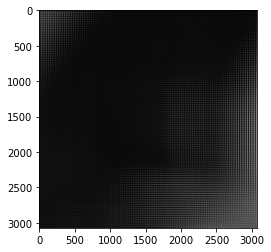

iteration: 1, error: 0.1222940508373219
iteration: 2, error: 0.0
iteration: 1, error: 0.26056151999985916
iteration: 2, error: 0.004762949050374908
iteration: 3, error: 0.22150351227457615
iteration: 4, error: 0.004216536692167803
iteration: 5, error: 0.18215492921491022


In [8]:
from ct_charachterization.utility.utils import broadcast_tile, block_matrix, \
    sum_over_each_neighborhood_on_blocked_matrix, expand, contract, central_gamma_pdf


y = img[0:128,0:128]
big_y = expand(small_img=y, neighborhood_size=32)
big_y = big_y[16 * 32:(128-16) * 32, 16 * 32:(128-16) * 32]
plt.imshow(big_y, cmap='gray')
plt.show()
big_y_stab = run_third_algorithm_with_gamma(big_y, mu, non_central=True, constant_c=10, neighborhood_size=32, max_iter=5)
y_stab = contract(big_img=big_y_stab, neighborhood_size=32)
sy = y_stab


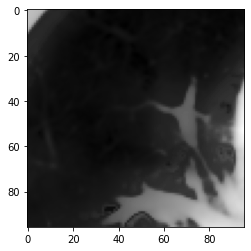

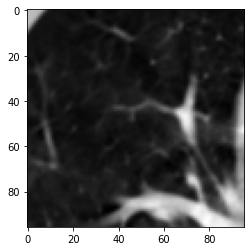

In [9]:
y = img[16:112,16:112]
plt.imshow(sy, cmap='gray')
plt.show()
plt.imshow(y, cmap='gray')
plt.show()

# Maybe we have solved the problem!
Surprisingly the stabilized image of lungs from the above has a lot in common with the right image below which is the stabilized image from the paper (Fig. 12):


![fig12](../resources/figs/fig12.png)

Lets look at the range and peaks.

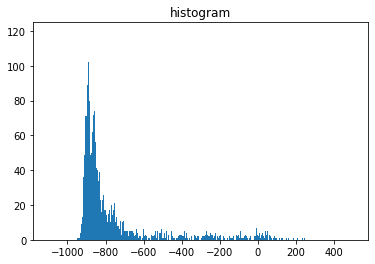

min: -949.3640220345352, mean: -753.1273376894621, max: 248.08081026167997


In [10]:
flat = sy.flatten() - 1030
ax = plt.subplot(1, 1, 1)
ax.hist(flat, bins=list(np.arange(-1100, 500, 1)))
plt.title("histogram")
plt.show()
print(f'min: {np.min(flat)}, mean: {np.mean(flat)}, max: {np.max(flat)}')